In [2]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

import sys
sys.path.append(os.path.abspath("/home/ros/llm_robot"))
from utils.pixel_to_cam_coords import detect_objects
from utils.camera import load_intrinsics
from utils.cam_to_base import cam2base
from utils.grasp_orientation import create_pcd_from_depth, segment_plane_from_pointcloud, pcd_to_surface_normal

### 큐브를 회전없이 놓은 경우
- 목표 Yaw
    - -180 -90 0 +90 +180

In [26]:
# 평행하게 놓은 상태
c_path = "/home/ros/llm_robot/data/captures/color/2025-08-04_14-16-14.jpg"
d_path = "/home/ros/llm_robot/data/captures/depth/2025-08-04_14-16-14.npy"
intr_path = "/home/ros/llm_robot/data/captures/intrinsics/2025-08-04_14-16-14.json"
ee2cam_path = "/home/ros/llm_robot/data/Calibration/Eye-in-Hand2/optimized_cam2ee_icp_point.json"
MODEL_DIR = "/home/ros/llm_robot/yolo/yolo11_seg_cube_best.pt"

camera_matrix, dist_coeffs = load_intrinsics(intr_path)

In [27]:
img = cv2.imread(c_path)

camera_matrix, dist_coeffs = load_intrinsics(intr_path)
result = detect_objects(c_path, d_path, ["cube"], camera_matrix, dist_coeffs, MODEL_DIR)


image 1/1 /home/ros/llm_robot/data/captures/color/2025-08-04_14-16-14.jpg: 384x640 1 cube, 7.6ms
Speed: 1.1ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

📦 추출된 객체 정보
cube        z=0.367 m  cam=(-0.021, -0.036, 0.367)


In [28]:
pcd = create_pcd_from_depth(d_path, intr_path, result)
plane_model, pcd = segment_plane_from_pointcloud(pcd)
rotation_matrix, yaw_angle = pcd_to_surface_normal(pcd)

In [29]:
coords = [81.6, -67.5, 299.4, -171.96, -3.71, -94.06]
base_coords = cam2base(result[0]["cam_xyz"], coords, rotation_matrix, yaw_angle, 
                    ee2cam_path, ee2cam = False)
base_coords

[180.4, -32.6, -168.1, -169.0, -5.0, -179.9]

In [30]:
# --- 1) segmented pcd에서 point 배열 가져오기 ---
points = np.asarray(pcd.points)           # (N,3) 배열

# --- 2) 중심(centroid)으로 원점 이동 ---
centroid = points.mean(axis=0)            # (3,)
points_centered = points - centroid       # (N,3)

# --- 3) 공분산 행렬 계산 ---
cov = np.cov(points_centered.T)           # (3,3)

# --- 4) 고유값·고유벡터 계산 ---
eigs, vecs = np.linalg.eigh(cov)
# 고유값 내림차순으로 정렬할 인덱스
order = np.argsort(eigs)[::-1]
# 주축 벡터들 (각 열이 주축 방향)
axes = vecs[:, order]                     # (3,3)

if np.linalg.det(axes) < 0:
    axes[:,2] *= -1

roll_pca, pitch_pca, yaw_pca = Rotation.from_matrix(axes).as_euler('xyz', degrees=True)
print(f"PCA‐based orientation after extrinsic correction:\n"
      f"  Roll:  {roll_pca:.2f}°\n"
      f"  Pitch: {pitch_pca:.2f}°\n"
      f"  Yaw:   {yaw_pca:.2f}°")

PCA‐based orientation after extrinsic correction:
  Roll:  -178.70°
  Pitch: -2.88°
  Yaw:   90.07°


In [31]:
roll, pitch, yaw = Rotation.from_matrix(axes).as_euler('xyz', degrees=True)

# (3) 각도를 [-180, 180) 범위로 정규화
#     Unity Inspector 방식: angle = (angle + 180) % 360 - 180
def normalize_angle(angle):
    a = (angle + 180) % 360 - 180                             # :contentReference[oaicite:0]{index=0}
    return a

roll = normalize_angle(roll)                                  # :contentReference[oaicite:1]{index=1}
pitch = normalize_angle(pitch)
yaw   = normalize_angle(yaw)

# (4) roll이 여전히 양수라면 360° 빼서 음수로 강제
if roll > 0:
    roll -= 360                                              # :contentReference[oaicite:2]{index=2}

# (5) 결과 출력
print(f"Enforced Negative Roll:\n  Roll: {roll:.2f}°  Pitch: {pitch:.2f}°  Yaw: {yaw:.2f}°")

Enforced Negative Roll:
  Roll: -178.70°  Pitch: -2.88°  Yaw: 90.07°


In [33]:
axis_length = np.linalg.norm(points - centroid, axis=1).max() * 0.3
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=axis_length,
    origin=np.zeros(3)
)

# 3) RPY → 3×3 회전행렬
R_rpy = Rotation.from_euler(
    'xyz',
    [roll_pca, pitch_pca, yaw_pca],
    degrees=True
).as_matrix()

# 4) 4×4 변환행렬로 결합 (회전 + 평행이동)
T = np.eye(4)
T[:3, :3] = R_rpy
T[:3, 3]  = centroid

frame.transform(T)

pts = np.asarray(pcd.points)
z = pts[:, 2]
z_norm = (z - z.min()) / (z.max() - z.min())    # 0~1 정규화
import matplotlib.pyplot as plt
cmap = plt.get_cmap("cool")
colors = cmap(z_norm)[:, :3]                   # RGBA → RGB
pcd.colors = o3d.utility.Vector3dVector(colors)

# 5) PCD와 함께 그리기
o3d.visualization.draw_plotly(
    [pcd, frame],
    window_name="PCA‐RPY Visualization",
    width=800, height=600
)

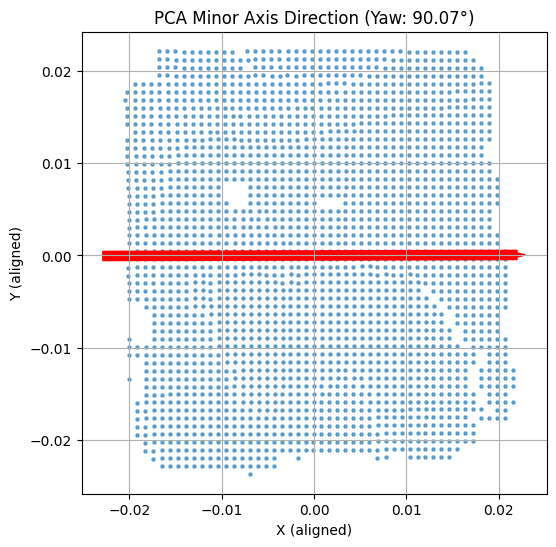

In [34]:
R_align_inv = rotation_matrix.T
points_aligned = (R_align_inv.dot(points_centered.T)).T  # shape (N,3)

# 3) XY평면(그리퍼 오픈 평면)으로 투영
proj2d = points_aligned[:, :2]  # (x, y) 좌표만 뽑음
# 1) 투영된 점들의 중심 계산
centroid_2d = proj2d.mean(axis=0)

# 2) 화살표 길이 설정 (투영 범위의 절반)
length = max(np.ptp(proj2d, axis=0)) * 0.5  # np.ptp 사용
minor_axis = vecs[:, -2]
dx, dy, _ = minor_axis * length

# 3) 플롯 그리기
plt.figure(figsize=(6,6))
plt.scatter(proj2d[:, 0], proj2d[:, 1], s=5, alpha=0.6)
plt.arrow(
    centroid_2d[0] - dx, centroid_2d[1] - dy,
    2 * dx, 2 * dy,
    head_width=0.02 * length,
    head_length=0.04 * length,
    length_includes_head=True,
    color='r'
)
plt.title(f"PCA Minor Axis Direction (Yaw: {yaw_pca:.2f}°)")
plt.xlabel("X (aligned)")
plt.ylabel("Y (aligned)")
plt.axis('equal')
plt.grid(True)
plt.show()

### 45도 회전하여 놓은 경우
- 원하는 목표 Yaw 각도
    - -135, -45, 45, 135 

In [ ]:
# 대각선
c_path = "/home/ros/llm_robot/data/captures/color/2025-08-04_15-27-57.jpg"
d_path = "/home/ros/llm_robot/data/captures/depth/2025-08-04_15-27-57.npy"
intr_path = "/home/ros/llm_robot/data/captures/intrinsics/2025-08-04_15-27-57.json"
ee2cam_path = "/home/ros/llm_robot/data/Calibration/Eye-in-Hand2/optimized_cam2ee_icp_point.json"

camera_matrix, dist_coeffs = load_intrinsics(intr_path)
img = cv2.imread(c_path)

camera_matrix, dist_coeffs = load_intrinsics(intr_path)
result = detect_objects(c_path, d_path, ["cube"], camera_matrix, dist_coeffs, MODEL_DIR)

coords = [81.6, -67.5, 299.4, -171.96, -3.71, -94.06]
base_coords = cam2base(result[0]["cam_xyz"], coords, rotation_matrix, yaw_angle, 
                    ee2cam_path, ee2cam = False)

pcd = create_pcd_from_depth(d_path, intr_path, result)
plane_model, pcd = segment_plane_from_pointcloud(pcd)
rotation_matrix, yaw_angle = pcd_to_surface_normal(pcd)

points = np.asarray(pcd.points)           # (N,3) 배열
centroid = points.mean(axis=0)            # (3,)
points_centered = points - centroid       # (N,3)
cov = np.cov(points_centered.T)           # (3,3)
eigs, vecs = np.linalg.eigh(cov)
order = np.argsort(eigs)[::-1]
axes = vecs[:, order]                     # (3,3)

if np.linalg.det(axes) < 0:
    axes[:,2] *= -1
    
# (5) 고유벡터 부호(Sign) 정정
# 첫 축이 물체의 전방(예: Z+)과 항상 양의 내적을 갖도록 강제한 뒤, 나머지 축도 오른손 법칙을 유지하며 뒤집기
if np.dot(axes[:,0], [0,0,1]) < 0:
    axes[:, 0] *= -1
    axes[:, 1] *= -1    # 오른손법 유지


roll_pca, pitch_pca, yaw_pca = Rotation.from_matrix(axes).as_euler('xyz', degrees=True)

#     Unity Inspector 방식: angle = (angle + 180) % 360 - 180
def normalize_angle(angle):
    a = (angle + 180) % 360 - 180                             # :contentReference[oaicite:0]{index=0}
    return a

roll_pca = normalize_angle(roll_pca)                                  # :contentReference[oaicite:1]{index=1}
pitch_pca = normalize_angle(pitch_pca)
yaw_pca   = normalize_angle(yaw_pca)

# (4) roll_pca이 여전히 양수라면 360° 빼서 음수로 강제
if roll_pca > 0:
    roll_pca -= 360                                              # :contentReference[oaicite:2]{index=2}

# (5) 결과 출력
print(f"Enforced Negative Roll_pca:\n  Roll_pca: {roll_pca:.2f}°  Pitch_pca: {pitch_pca:.2f}°  Yaw_pca: {yaw_pca:.2f}°")


image 1/1 /home/ros/llm_robot/data/captures/color/2025-08-04_15-27-57.jpg: 384x640 1 cube, 7.7ms
Speed: 1.1ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

📦 추출된 객체 정보
cube        z=0.355 m  cam=(-0.196, -0.046, 0.355)
PCA‐based orientation after extrinsic correction:
  Roll:  -177.66°
  Pitch: -6.81°
  Yaw:   31.32°
Enforced Negative Roll_pca:
  Roll_pca: -177.66°  Pitch_pca: -6.81°  Yaw_pca: 31.32°


In [43]:
axis_length = np.linalg.norm(points - centroid, axis=1).max() * 0.3
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=axis_length,
    origin=np.zeros(3)
)

# 3) RPY → 3×3 회전행렬
R_rpy = Rotation.from_euler(
    'xyz',
    [roll_pca, pitch_pca, yaw_pca],
    degrees=True
).as_matrix()

# 4) 4×4 변환행렬로 결합 (회전 + 평행이동)
T = np.eye(4)
T[:3, :3] = R_rpy
T[:3, 3]  = centroid

frame.transform(T)

pts = np.asarray(pcd.points)
z = pts[:, 2]
z_norm = (z - z.min()) / (z.max() - z.min())    # 0~1 정규화
import matplotlib.pyplot as plt
cmap = plt.get_cmap("cool")
colors = cmap(z_norm)[:, :3]                   # RGBA → RGB
pcd.colors = o3d.utility.Vector3dVector(colors)

# 5) PCD와 함께 그리기
o3d.visualization.draw_plotly(
    [pcd, frame],
    window_name="PCA‐RPY Visualization",
    width=800, height=600
)

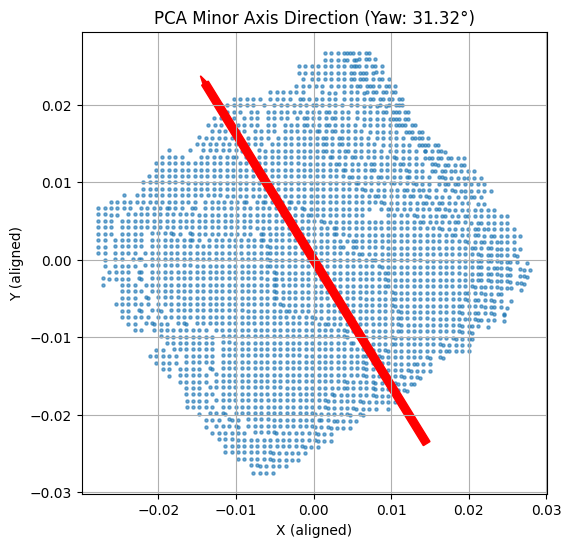

In [44]:
R_align_inv = rotation_matrix.T
points_aligned = (R_align_inv.dot(points_centered.T)).T  # shape (N,3)

# 3) XY평면(그리퍼 오픈 평면)으로 투영
proj2d = points_aligned[:, :2]  # (x, y) 좌표만 뽑음
# 1) 투영된 점들의 중심 계산
centroid_2d = proj2d.mean(axis=0)

# 2) 화살표 길이 설정 (투영 범위의 절반)
length = max(np.ptp(proj2d, axis=0)) * 0.5  # np.ptp 사용
minor_axis = vecs[:, -2]
dx, dy, _ = minor_axis * length

# 3) 플롯 그리기
plt.figure(figsize=(6,6))
plt.scatter(proj2d[:, 0], proj2d[:, 1], s=5, alpha=0.6)
plt.arrow(
    centroid_2d[0] - dx, centroid_2d[1] - dy,
    2 * dx, 2 * dy,
    head_width=0.02 * length,
    head_length=0.04 * length,
    length_includes_head=True,
    color='r'
)
plt.title(f"PCA Minor Axis Direction (Yaw: {yaw_pca:.2f}°)")
plt.xlabel("X (aligned)")
plt.ylabel("Y (aligned)")
plt.axis('equal')
plt.grid(True)
plt.show()

1. Surface Normal(r,p) + PCA(yaw)
- 실험1 roll 오차: 11
- 실험2 roll 오차: 12.8

- 실험1 pitch 오차: 2.6
- 실험2 pitch 오차: 0.2

- 실험1 yaw 오차: 0.11
- 실험2 yaw 오차: 8.41

2. PCA (r,p y)
- 실험1 roll 오차: 1.3
- 실험2 roll 오차: 2.07

- 실험1 pitch 오차: 2.88
- 실험2 pitch 오차: 8.75

- 실험1 yaw 오차: 0.07
- 실험2 yaw 오차: 8.75